In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
a2emmc_path = os.path.join(os.environ['HOME'], 'a2e-mmc')
nwtc_path = os.path.join(os.environ['HOME'], 'NWTC')
if not a2emmc_path in sys.path:
    sys.path.append(a2emmc_path)
if not nwtc_path in sys.path:
    sys.path.append(nwtc_path)

In [3]:
import numpy as np
import pandas as pd

In [4]:
from datatools.SOWFA6.postProcessing.sourceHistory import SourceHistory
from mmctools.plotting import plot_timehistory_at_height
from mmctools.coupling.sowfa import InternalCoupling

# 1. Load data

In [5]:
#dateref = '2013-11-08 00:00:00'
dateref = None

In [6]:
datadir = 'sourceHistory'
#datadir = '/scratch/mchurchf/equinor.FY19/precursor.singleRow.neutral.10mps/postProcessing/sourceHistory/'
#datadir = '/scratch/dallaert/SWIFTtency/run.tency.w0_L0/postProcessing/sourceHistory/'

outputdir = '.'

In [7]:
#%%time
src = SourceHistory(datadir)
print(src)

Simulation (re)start times: [20000.0]
  read Momentum
  read Temperature
Times read: 1729 [20001.7079346 20003.8436227 20005.9808844 ... 23596.0824066 23598.0412033
 23600.       ]
Fields read:
  Momentum : (1729, 1, 3)
  Temperature : (1729, 1)



In [8]:
#%%time
df = src.to_pandas()

Creating dataframe for [20001.7079346 20003.8436227 20005.9808844 ... 23596.0824066 23598.0412033
 23600.       ]


In [9]:
df.reset_index(level='z',inplace=True)
df.columns = ['height','Fx','Fy','Fz','Ft']

In [10]:
df.reset_index(inplace=True)
df['t'] = pd.to_timedelta(df.t,unit='s')
df.set_index('t',inplace=True)

In [11]:
df.head()

,height,Fx,Fy,Fz,Ft
t,,,,,
05:33:21.707934,0.0,0.000228,0.000779,0.0,0.0
05:33:23.843622,0.0,0.000321,0.000777,0.0,0.0
05:33:25.980884,0.0,0.000319,0.000773,0.0,0.0
05:33:28.115455,0.0,0.000318,0.000769,0.0,0.0
05:33:30.246075,0.0,0.000317,0.000765,0.0,0.0


# 2. Process and inspect data

In [12]:
# Compute 10-min averages
heights = df['height'].unique()
if len(heights) > 1:
    df10 = df.pivot(columns='height',values=['Fx','Fy','Fz','Ft']
                   ).resample('10min').mean().stack().reset_index(level='height')
else:
    assert len(heights) == 1
    # constant source terms with height
    df10 = df.resample('10min').mean()
    df10['height'] = heights[0]

In [13]:
df10.head()

,height,Fx,Fy,Fz,Ft
t,,,,,
05:33:21.707934,0.0,0.000363,0.000876,0.0,0.0
05:43:21.707934,0.0,0.000363,0.000933,0.0,0.0
05:53:21.707934,0.0,0.000314,0.000931,0.0,0.0
06:03:21.707934,0.0,0.000369,0.000908,0.0,0.0
06:13:21.707934,0.0,0.000357,0.000912,0.0,0.0


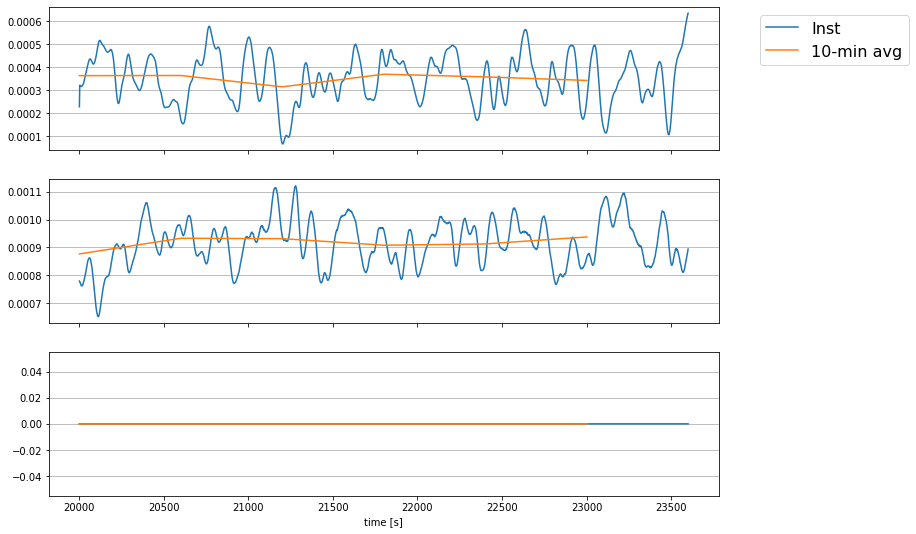

In [14]:
fig,ax = plot_timehistory_at_height({'Inst':df,'10-min avg':df10},fields=['Fx','Fy','Ft'],heights=0)

# 3. Write data

In [15]:
#%%time
timeheight_to_sowfa = InternalCoupling(outputdir,df,dateref)
#timeheight_to_sowfa.write_timeheight('forcingTable',xmom='Fx',ymom='Fy',zmom='Fz',temp='Ft')
timeheight_to_sowfa.write_timeheight('forcingTableMomentum',xmom='Fx',ymom='Fy',zmom='Fz')
timeheight_to_sowfa.write_timeheight('forcingTableTemperature',temp='Ft')